In [771]:
import pandas as pd
import pandas_ta as ta

In [772]:
df = pd.read_csv("../data/1h/TRMD.csv")
df.set_index("Datetime", inplace=True)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-01-05 09:30:00-05:00,7.540000,7.65,7.352700,7.620000,14007,0.0,0.0
2021-01-05 11:30:00-05:00,7.600000,7.61,7.580000,7.580000,600,0.0,0.0
2021-01-05 12:30:00-05:00,7.596300,7.65,7.561000,7.600000,5577,0.0,0.0
2021-01-05 13:30:00-05:00,7.600000,7.65,7.600000,7.650000,353,0.0,0.0
2021-01-05 14:30:00-05:00,7.632400,7.65,7.632400,7.645000,1472,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-23 11:30:00-04:00,26.111200,26.49,26.010000,26.459999,26255,0.0,0.0
2023-05-23 12:30:00-04:00,26.480000,26.48,26.200001,26.290001,42493,0.0,0.0
2023-05-23 13:30:00-04:00,26.280001,26.43,26.125000,26.157301,20594,0.0,0.0


In [773]:
import numpy as np

# Squeeze Momentum Indicator

LENGTH_BB = 20 # BB Length
MULT_BB = 2 # BB Multiplier
LENGTH_KC = 20 # KC Length
MULT_KC = 1.5 # KC Multiplier

USE_TRUE_RANGE = True # Use True Range for KC

# Calculate BB
source = df["Close"]
basis = ta.sma(source, length=LENGTH_BB)
dev = MULT_KC * ta.stdev(source, length=LENGTH_BB)

upperBB = basis + dev
lowerBB = basis - dev

# Calculate KC
ma = ta.sma(source, length=LENGTH_KC)
range_val = ta.true_range(df["High"], df["Low"], df["Close"]) if USE_TRUE_RANGE else df["High"] - df["Low"]
rangema = ta.sma(range_val, length=LENGTH_KC)
upperKC = ma + rangema * MULT_KC
lowerKC = ma - rangema * MULT_KC

# Calculate Squeeze
sqzOn = (lowerBB > lowerKC) & (upperBB < upperKC)
sqzOff = (lowerBB < lowerKC) & (upperBB > upperKC)
noSqz = ~sqzOn & ~sqzOff

# Calculate Momentum
avg_high_low = (df["High"].rolling(LENGTH_KC).max() + df["Low"].rolling(LENGTH_KC).min())/2
sma_close = ta.sma(df["Close"], LENGTH_KC)
val = ta.linreg(source - (avg_high_low + sma_close)/2, LENGTH_KC, 0)

# replace all NaN values with 0
val = val.replace(np.nan, 0)

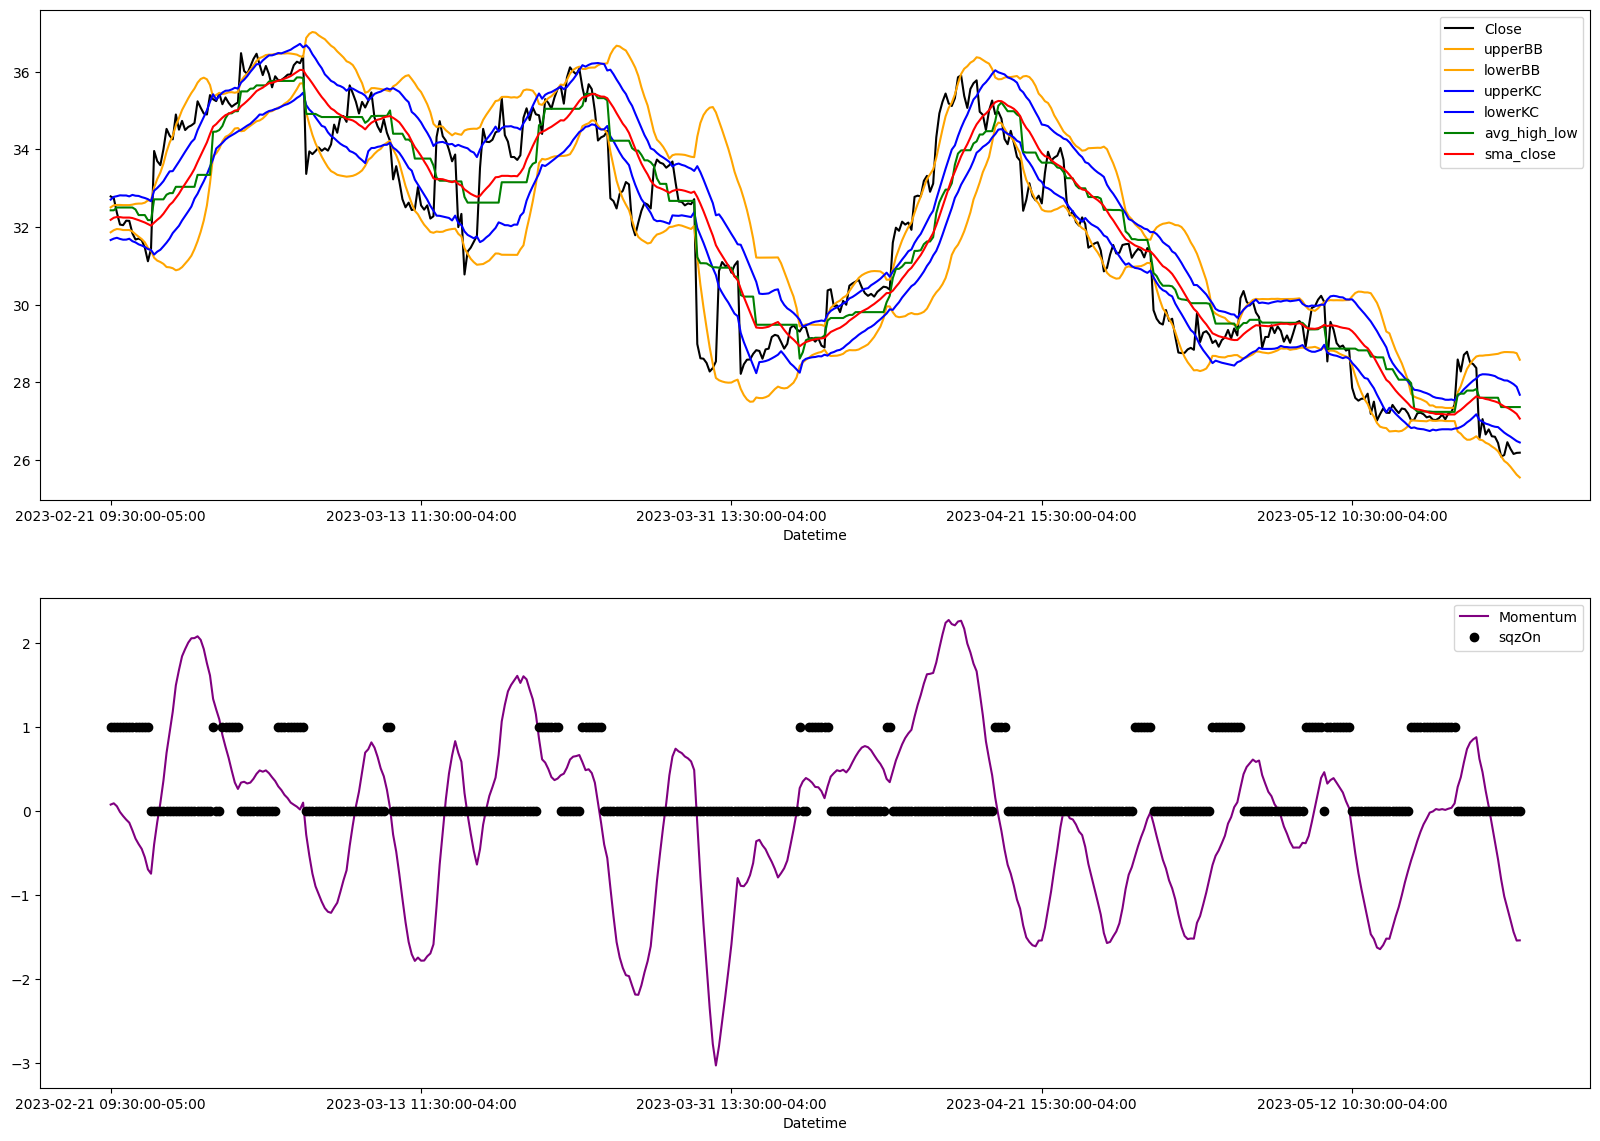

In [774]:
cutoff = "2023-02-20"
df = df[df.index > cutoff]
upperBB = upperBB[upperBB.index > cutoff]
lowerBB = lowerBB[lowerBB.index > cutoff]
upperKC = upperKC[upperKC.index > cutoff]
lowerKC = lowerKC[lowerKC.index > cutoff]
avg_high_low = avg_high_low[avg_high_low.index > cutoff]
sma_close = sma_close[sma_close.index > cutoff]
sqzOn = sqzOn[sqzOn.index > cutoff]
sqzOff = sqzOff[sqzOff.index > cutoff]
val = val[val.index > cutoff]

import matplotlib.pyplot as plt
# set figsize big height
plt.subplot(2, 1, 1)

# plot the data
df["Close"].plot(figsize=(20,80), color="black")
upperBB.plot(figsize=(20,8), color="orange")
lowerBB.plot(figsize=(20,8), color="orange")
upperKC.plot(figsize=(20,8), color="blue")
lowerKC.plot(figsize=(20,8), color="blue")

avg_high_low.plot(figsize=(20,8), color="green")
sma_close.plot(figsize=(20,8), color="red")

plt.legend(["Close", "upperBB", "lowerBB", "upperKC", "lowerKC", "avg_high_low", "sma_close"])

plt.subplot(2, 1, 2)
val.plot(figsize=(20,80), color="purple")

# plot dots where sqzOn is true, and crosses where sqzOff is true
sqzOn.astype(int).plot(figsize=(20,14), color="black", marker="o", linestyle="None")

plt.legend(["Momentum", "sqzOn"])

In [775]:
lefbars = 5
rightbars = 5
volume_threshold = 10


In [776]:
from collections import deque
import numpy as np


def clean_deque(i, k, deq, df, key, isHigh):
    if deq and deq[0] == i - k:
        deq.popleft()
    if isHigh:
        while deq and df.iloc[i][key] > df.iloc[deq[-1]][key]:
            deq.pop()
    else:
        while deq and df.iloc[i][key] < df.iloc[deq[-1]][key]:
            deq.pop()

def pivotPoints(pivot=None,data=None):
    """
    This function calculates the pivot points based on the pivot lenght.
    These can be HH, LH , HL, LL values based on the adjacent pivots 
    which occur based on the length of the pivot.
    """

    data['PH'] = False
    data['PHV'] = np.NaN
    data['PL'] = False
    data['PLV'] = np.NaN
    keyHigh = 'High'
    keyLow = 'Low'
    win_size = pivot * 2 + 1
    deqHigh = deque()
    deqLow = deque()
    max_idx = 0
    min_idx = 0
    i = 0
    j = pivot
    pivot_low = None
    pivot_high = None
    for index, row in data.iterrows():
        if i < win_size:
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)
            if data.iloc[i][keyHigh] > data.iloc[max_idx][keyHigh]:
                max_idx = i
            if data.iloc[i][keyLow] < data.iloc[min_idx][keyLow]:
                min_idx = i
            if i == win_size-1:
                if data.iloc[max_idx][keyHigh] == data.iloc[j][keyHigh]:
                    data.at[data.index[j], 'PH'] = True
                    pivot_high = data.iloc[j][keyHigh]
                if data.iloc[min_idx][keyLow] == data.iloc[j][keyLow]:
                    data.at[data.index[j], 'PL'] = True
                    pivot_low = data.iloc[j][keyLow]
        if i >= win_size:
            j += 1
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)
            pivot_val = data.iloc[deqHigh[0]][keyHigh]
            if pivot_val == data.iloc[j][keyHigh]:
                data.at[data.index[j], 'PH'] = True
                pivot_high = data.iloc[j][keyHigh]
            if data.iloc[deqLow[0]][keyLow] == data.iloc[j][keyLow]:
                data.at[data.index[j], 'PL'] = True
                pivot_low = data.iloc[j][keyLow]

        data.at[data.index[j], 'PHV'] = pivot_high
        data.at[data.index[j], 'PLV'] = pivot_low
        i = i + 1

    return data

In [777]:
pivots = pivotPoints(pivot=1,data=df)
pivots

/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_6847/2714517808.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PH'] = False
/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_6847/2714517808.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PHV'] = np.NaN
/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_6847/2714517808.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,Open,High,Low,Close,Volume,Dividends,Stock Splits,PH,PHV,PL,PLV
Datetime,,,,,,,,,,,
2023-02-21 09:30:00-05:00,32.490002,33.250000,32.330002,32.790001,71502,0.0,0.0,False,NaN,False,NaN
2023-02-21 10:30:00-05:00,32.839001,33.215000,32.689999,32.744999,36604,0.0,0.0,False,NaN,False,NaN
2023-02-21 11:30:00-05:00,32.744999,32.744999,32.320000,32.369999,20868,0.0,0.0,False,NaN,False,NaN
2023-02-21 12:30:00-05:00,32.450001,32.549900,31.959999,32.064999,32168,0.0,0.0,False,NaN,False,NaN
2023-02-21 13:30:00-05:00,32.001900,32.113300,31.840000,32.049999,15257,0.0,0.0,False,NaN,True,31.840000
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23 11:30:00-04:00,26.111200,26.490000,26.010000,26.459999,26255,0.0,0.0,True,26.49,False,25.860001
2023-05-23 12:30:00-04:00,26.480000,26.480000,26.200001,26.290001,42493,0.0,0.0,False,26.49,False,25.860001
2023-05-23 13:30:00-04:00,26.280001,26.430000,26.125000,26.157301,20594,0.0,0.0,False,26.49,False,25.860001


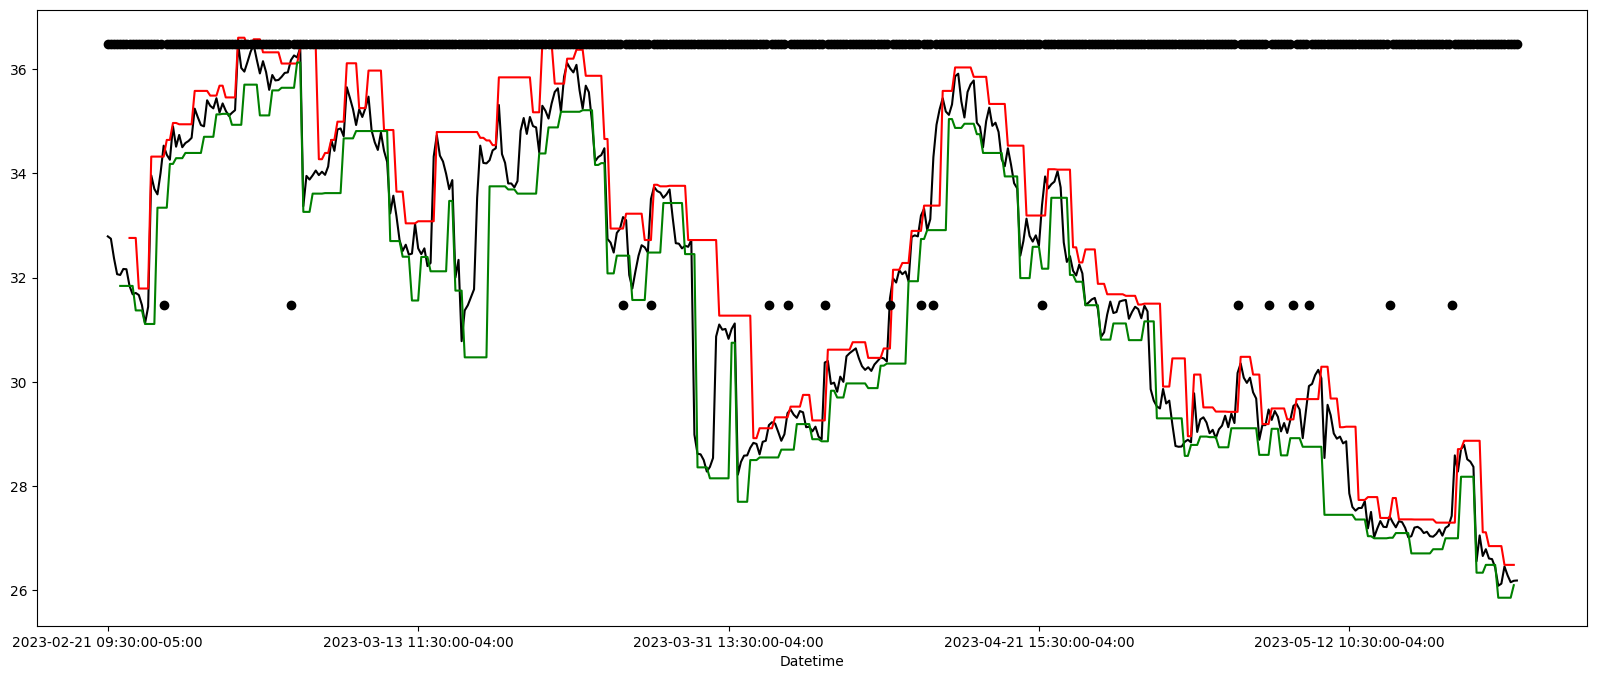

<Axes: xlabel='Datetime'>

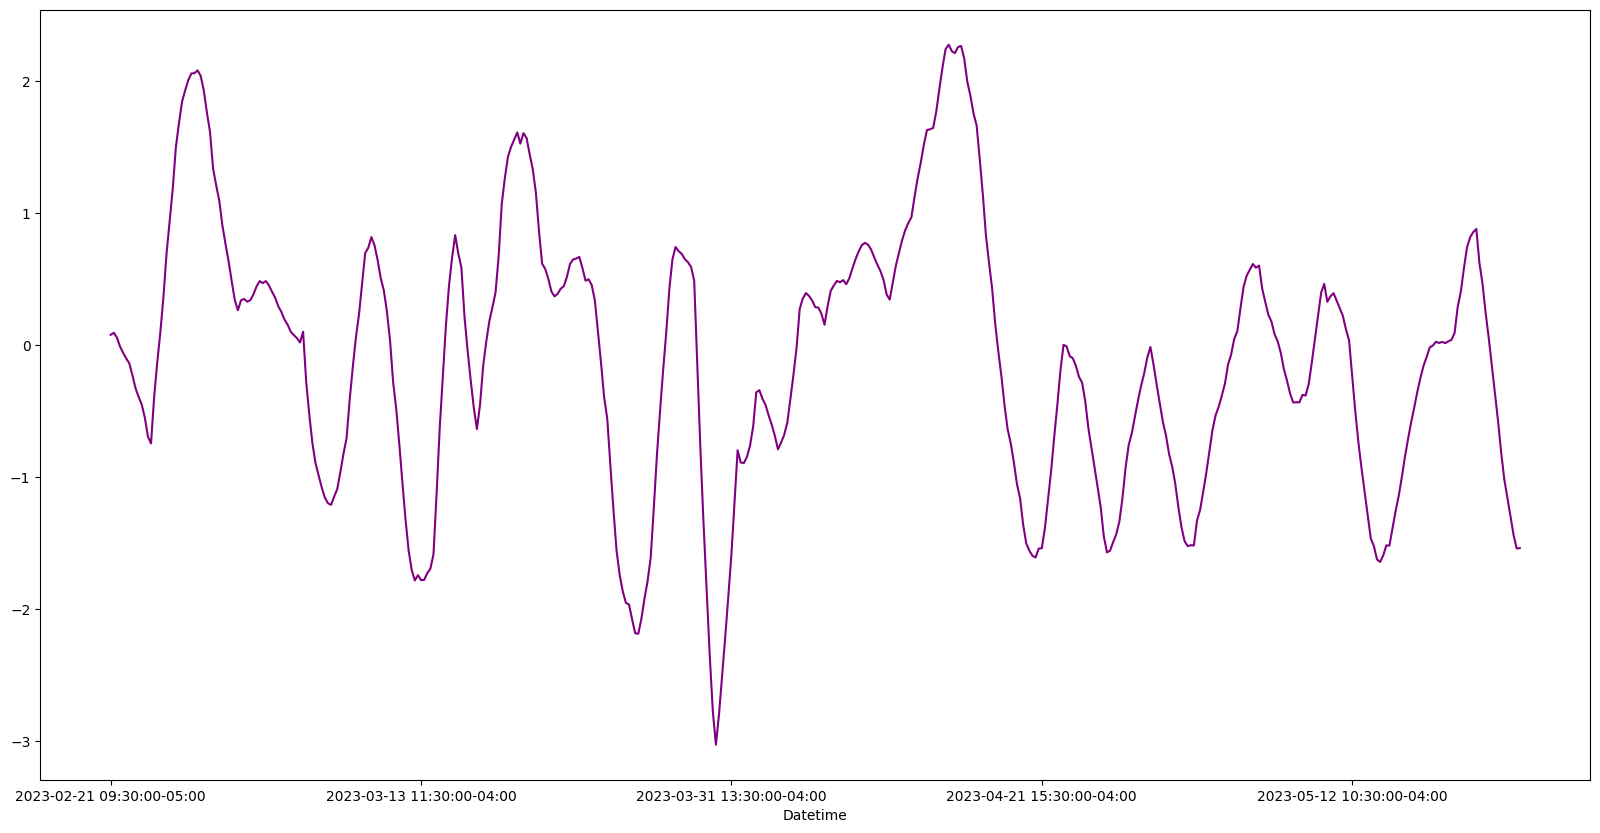

In [778]:
# graph pivots on top of price
df["Close"].plot(figsize=(20,8), color="black")

pivots["PHV"].plot(figsize=(20,8), color="red")
pivots["PLV"].plot(figsize=(20,8), color="green")
short = ta.ema(df["Volume"], 5)
long = ta.ema(df["Volume"], 10)
osc = 100*(short - long) / long


bull_cond = df["Open"] - df["Low"] > df["Close"] - df["Open"]
bull_break = ta.cross(df["Close"], pivots["PHV"]) & ~bull_cond #& (osc > volume_threshold)

(bull_break.astype(int)*-5+max(df["Close"])).plot(figsize=(20,8), color="black", marker="o", linestyle="None")

plt.show()
val.plot(figsize=(20,10), color="purple")

# plot dots where sqzOn is true, and crosses where sqzOff is true
# sqzOn.astype(int).plot(figsize=(20,14), color="pink", marker="o", linestyle="None", alpha=0.5)

<Axes: xlabel='Datetime'>

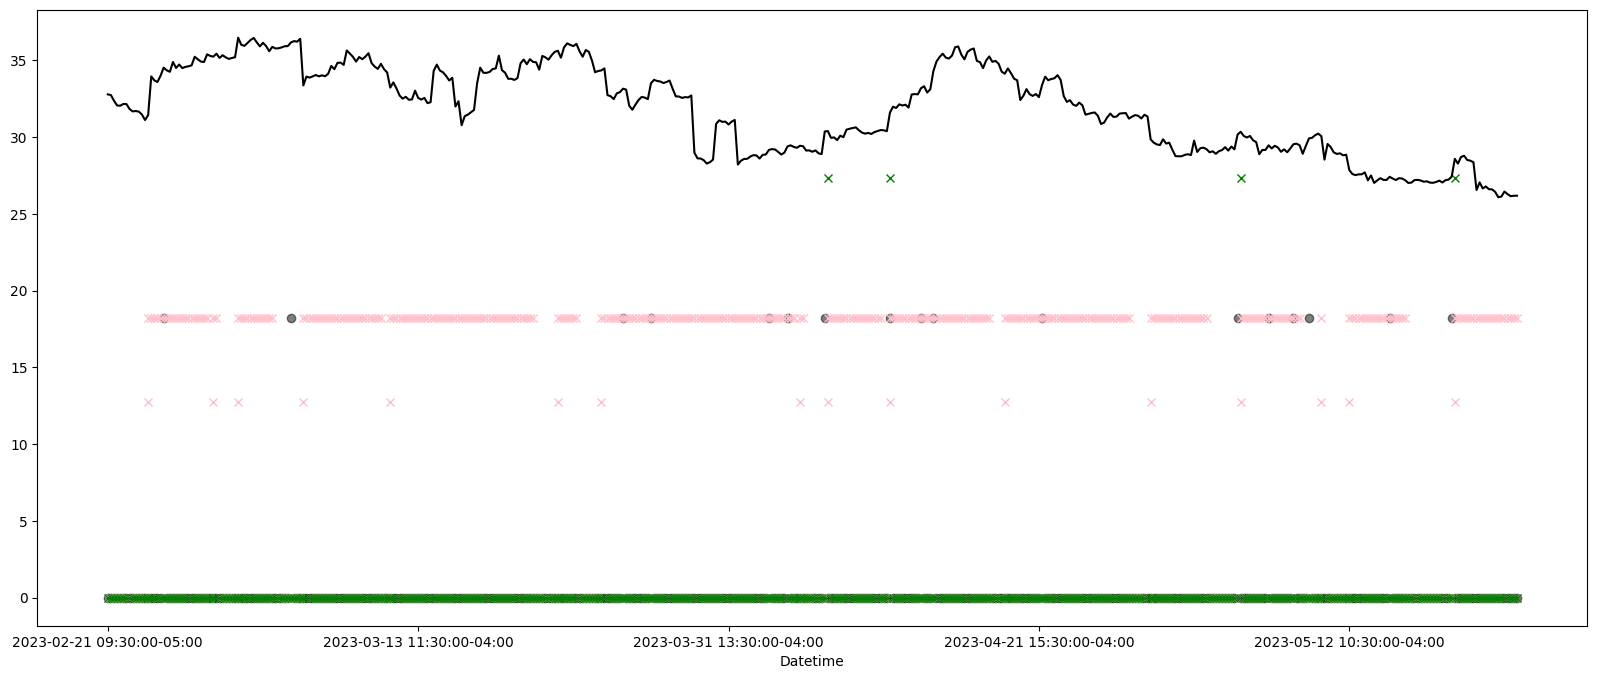

In [779]:
# identify where the squeeze turns off at the same time as a bull break

mult = 1/2 * max(df["Close"])
SENSITIVITY = 4

(bull_break.astype(int)*mult).plot(figsize=(20,8), color="black", marker="o", linestyle="None", alpha=0.5)
# sqzOff = sqzOff.astype(int).rolling(4).sum().astype(bool)
(sqzOff.astype(int)*mult).plot(figsize=(20,8), color="pink", marker="x", linestyle="None", alpha=1)

sqzTurnOff = sqzOff & ~sqzOff.shift(1).dropna()

(sqzTurnOff.astype(int)*.7*mult).plot(figsize=(20,8), color="pink", marker="x", linestyle="None", alpha=1)

intersect = bull_break.astype(int).rolling(SENSITIVITY).sum().astype(bool) & sqzTurnOff.astype(int).rolling(SENSITIVITY).sum().astype(bool)

# resample intersect to only have 1 consecutive buy signal
intersect = intersect & ~intersect.shift(1).dropna()

(intersect.astype(int)*1.5*mult).plot(figsize=(20,8), color="green", marker="x", linestyle="None", alpha=1)


# plot price
df["Close"].plot(figsize=(20,8), color="black")

In [702]:
# get the dates of the intersect == true
intersect_dates = intersect[intersect == True].index
intersect_dates

Index(['2023-03-31 15:30:00-04:00'], dtype='object', name='Datetime')